<a href="https://colab.research.google.com/github/saksham096/sakhsam096.github.io/blob/main/patchtst_voltage_forecasting_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PatchTST Forecasting of 5-Channel Voltage Time‑Series

This notebook loads the 5‑channel voltage measurements, frames a supervised forecasting task, and trains a PatchTST model (Nie et al., 2023) using the original implementation shipped with the paper.

In [ ]:

# Standard libs
import os, sys, zipfile, json, random, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
# Torch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


In [ ]:
# Step 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.listdir('/content/drive/MyDrive/PatchTST/ProteinoidChannelData_MLModel_1')


Mounted at /content/drive


['book1.pdf',
 'OneDrive_2025-05-10.zip',
 'Data_Graph.jpeg',
 'book2.pdf',
 '5506_a_time_series_is_worth_64_word.pdf',
 'patchtst.pdf',
 'OneDrive_2025-05-10',
 'README.txt',
 'PatchTST-main.zip',
 'PatchTST-main',
 'channels5_data.xlsx',
 'Model Tuning.gsheet',
 'patchtst_voltage_forecasting.ipynb']

In [ ]:
base_dir = '/content/drive/MyDrive/PatchTST/ProteinoidChannelData_MLModel_1'
data_path = os.path.join(base_dir, 'channels5_data.xlsx')
patch_zip_path = os.path.join(base_dir, 'PatchTST-main.zip')
patch_repo_path = os.path.join(base_dir, 'PatchTST-main')

# Extract PatchTST repo if not yet extracted
if not os.path.isdir(patch_repo_path):
    with zipfile.ZipFile(patch_zip_path) as z:
        z.extractall(base_dir)
print('PatchTST repo ready at', patch_repo_path)
# Add repo's supervised folder to sys.path
sup_path = os.path.join(patch_repo_path, 'PatchTST_supervised')
if sup_path not in sys.path:
    sys.path.append(sup_path)
# Imports from repo
from models.PatchTST import Model as PatchTSTModel


PatchTST repo ready at /content/drive/MyDrive/PatchTST/ProteinoidChannelData_MLModel_1/PatchTST-main


In [ ]:

# Load the 5‑channel worksheet
df = pd.read_excel(data_path)
print('Raw shape:', df.shape)
display(df.head())
# Assume first column is time index or create default
if df.columns[0].lower().startswith('time'):
    df = df.set_index(df.columns[0])
else:
    # Use integer index if no explicit time column
    df.index = pd.RangeIndex(len(df))
# Ensure we only have 5 numeric columns
#print('Raw shape:', df2)
#df = df.select_dtypes(include=[np.number]).iloc[: , :5]
df = df.iloc[:,1:6]
print(df.shape)
df.columns = [f'Ch{i+1}' for i in range(df.shape[1])]
#df = df.select_dtypes(include=['number'])

print(df.dtypes)
#print(df['Ch1'].astype(str))

# Convert all object columns to numeric (non-convertible = NaN)
df_numeric = df.apply(lambda col: pd.to_numeric(col, errors='coerce'))

# Drop rows where **all values** are NaN
df = df[~df_numeric.isna().all(axis=1)]

#Drop last 5 rows, outliers, huge values -- clean the dataset
df = df.iloc[:71998,:]

print('Prepared data shape:', df.shape)

Raw shape: (72006, 6)


,Unnamed: 0,Ch 1,Ch 2,Ch 3,Ch 4,Ch 5
0,101 Time (s),108 Voltage (V),107 Voltage (V),101 Voltage (V),102 Voltage (V),106 Voltage (V)
1,0,-0.00302,0.09275,-0.01861,-0.00336,0.34104
2,0.91619,-0.00143,0.09429,-0.01723,-0.00544,0.33914
3,1.91626,-0.000886,0.09337,-0.01638,-0.00627,0.33657
4,2.91626,-0.00197,0.09245,-0.01523,-0.01001,0.33549


(72006, 5)
Ch1    object
Ch2    object
Ch3    object
Ch4    object
Ch5    object
dtype: object
Prepared data shape: (71998, 5)


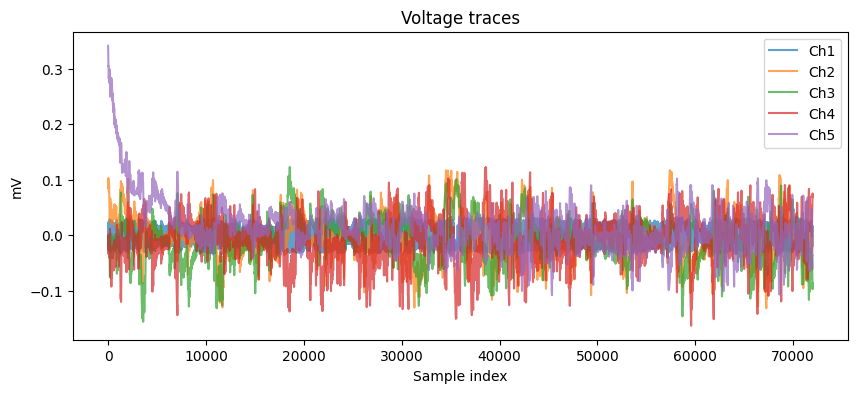

In [ ]:

# Quick glance at the signals
plt.figure(figsize=(10,4))
for c in df.columns:
    #print(df[c].astype(float))
    plt.plot(df.index, df[c], label=c, alpha=0.7)
plt.legend()
plt.title('Voltage traces')
plt.xlabel('Sample index')
plt.ylabel('mV')
plt.show()


In [ ]:

# Baseline-correct using first 10 samples
baseline = df.iloc[:10].mean()
df_bc = df - baseline
# Z‑score normalisation (channelwise)
mu, sigma = df_bc.mean(), df_bc.std()
df_norm = (df_bc - mu) / sigma
df_norm.head()


,Ch1,Ch2,Ch3,Ch4,Ch5
1,-0.131242,2.307239,-0.273803,0.099608,7.118769
2,-0.044343,2.34447,-0.238302,0.051477,7.077143
3,-0.014637,2.322228,-0.216435,0.032271,7.020838
4,-0.073856,2.299986,-0.186851,-0.054272,6.997176
5,-0.175511,2.285964,-0.153151,-0.133178,6.972639


In [ ]:

class PatchTSTDataset(Dataset):
    def __init__(self, array, seq_len=256, pred_len=32, patch_len=16, stride=16):
        self.X, self.y = [], []
        self.seq_len = seq_len; self.pred_len = pred_len
        self.patch_len = patch_len; self.stride = stride
        self.series = array.astype('float32')
        # slide
        for t0 in range(0, len(self.series)-seq_len-pred_len):
            win = self.series[t0:t0+seq_len]      # (seq_len, C)
            targ = self.series[t0+seq_len : t0+seq_len+pred_len]
            self.X.append(win)
            self.y.append(targ)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x = self.X[idx]  # (seq_len, C)
        y = self.y[idx]  # (pred_len, C)
        return torch.from_numpy(x), torch.from_numpy(y)




In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, random_split


# Parameters
SEQ_LEN   = 256
PRED_LEN  = 32
PATCH_LEN = 16
STRIDE    = 8
BATCH     = 32

# Use normalized data as numpy array
data_arr = df_norm.values  # shape: (T, C)

# Create dataset
full_ds = PatchTSTDataset(data_arr, SEQ_LEN, PRED_LEN, PATCH_LEN, STRIDE)

# Split into train/val
n_total = len(full_ds)
val_size = int(0.15 * n_total)
train_size = n_total - val_size
train_ds, val_ds = random_split(full_ds, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False, drop_last=True)


In [ ]:

!pip install -q optuna torch-optimizer

import torch
import optuna
from types import SimpleNamespace
from functools import partial

# Define training loop
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = torch.nn.MSELoss()(pred, yb)
        loss.backward()
        optimizer.step()

# Define evaluation loop
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    count = 0
    criterion = torch.nn.MSELoss()
    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            total_loss += loss.item() * xb.size(0)
            count += xb.size(0)
    return total_loss / count

# Define Optuna objective
def objective(trial, train_dl, val_dl, device):
    patch_len = trial.suggest_categorical("patch_len", [16, 24, 32, 48])
    stride = trial.suggest_int("stride", 1, patch_len - 1)  # ✅ ensure stride < patch_len
    d_model = trial.suggest_categorical("d_model", [128, 192, 256, 320])
    e_layers = trial.suggest_int("e_layers", 4, 8)  # ✅ deeper models
    dropout = trial.suggest_float("dropout", 0.05, 0.3, step=0.05)

    configs = SimpleNamespace(
        enc_in        = 5,
        patch_len     = patch_len,
        stride        = stride,
        d_model       = d_model,
        e_layers      = e_layers,
        dropout       = dropout,
        fc_dropout    = 0.1,
        head_dropout  = 0.1,
        revin         = True,
        affine        = True,
        subtract_last = False,
        padding_patch = 0,
        decomposition = False,
        kernel_size   = 25,
        n_heads       = max(1, d_model // 8),  # ✅ higher attention width
        d_ff          = 256,
        seq_len       = 256,
        pred_len      = 32,
        n_layers      = e_layers,
        individual    = False,
        activation    = "gelu"
    )

    model = PatchTSTModel(configs).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    best = float('inf')
    for ep in range(8):
        train_one_epoch(model, train_dl, optimizer, device)
        val_loss = evaluate(model, val_dl, device)
        trial.report(val_loss, ep)
        if trial.should_prune():
            raise optuna.TrialPruned()
        best = min(best, val_loss)

    return best

# Ensure this line appears after DataLoader setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Run tuning
study = optuna.create_study(direction="minimize",
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=2))
study.optimize(partial(objective,
                       train_dl=train_loader,
                       val_dl=val_loader,
                       device=device),
               n_trials=50)

# Save all trials to CSV
import pandas as pd
df_trials = study.trials_dataframe(attrs=("number", "value", "params", "state"))
df_trials.to_csv("optuna_patchtst_trials.csv", index=False)
print("📄 Trial history saved to optuna_patchtst_trials.csv")

# Notify best checkpoint saved
print("📌 Best model checkpoint saved as 'best_model.pt'")


print("✅ Best params:", study.best_trial.params)





[I 2025-05-24 14:54:52,589] A new study created in memory with name: no-name-dfc7233b-afc2-4485-8f06-fb52795d40f9
[I 2025-05-24 15:02:41,580] Trial 0 finished with value: 0.16896858323542846 and parameters: {'patch_len': 48, 'stride': 14, 'd_model': 192, 'e_layers': 7, 'dropout': 0.15000000000000002}. Best is trial 0 with value: 0.16896858323542846.
[I 2025-05-24 15:28:24,727] Trial 1 finished with value: 0.17281081680474536 and parameters: {'patch_len': 48, 'stride': 5, 'd_model': 320, 'e_layers': 5, 'dropout': 0.05}. Best is trial 0 with value: 0.16896858323542846.
[I 2025-05-24 15:37:48,525] Trial 2 finished with value: 0.18257650797299685 and parameters: {'patch_len': 16, 'stride': 13, 'd_model': 192, 'e_layers': 7, 'dropout': 0.25}. Best is trial 0 with value: 0.16896858323542846.
[I 2025-05-24 15:44:44,869] Trial 3 finished with value: 0.13874559100007727 and parameters: {'patch_len': 32, 'stride': 31, 'd_model': 192, 'e_layers': 7, 'dropout': 0.05}. Best is trial 3 with value: 0

📄 Trial history saved to optuna_patchtst_trials.csv
📌 Best model checkpoint saved as 'best_model.pt'
✅ Best params: {'patch_len': 24, 'stride': 4, 'd_model': 128, 'e_layers': 8, 'dropout': 0.05}


In [ ]:
SEQ_LEN    = 256
PRED_LEN   = 32
PATCH_LEN  = 16
STRIDE     = 8



from types import SimpleNamespace

best_cfg = SimpleNamespace(
    enc_in = 5,
    patch_len = 24,
    stride = 4,
    d_model = 128,
    e_layers = 8,
    dropout = 0.05,
    fc_dropout = 0.1,
    head_dropout = 0.1,
    revin = True,
    affine = True,
    subtract_last = False,
    padding_patch = 0,
    decomposition = False,
    kernel_size = 25,
    n_heads = 8,  # usually d_model // 16
    d_ff = 256,
    seq_len = 256,
    pred_len = 32,
    n_layers = 8,
    individual = False,
    activation = "gelu"
)

model = PatchTSTModel(best_cfg)

print('Model parameters:', sum(p.numel() for p in model.parameters()) / 1e3, 'K')



Model parameters: 1312.306 K


In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PatchTSTModel(best_cfg).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
EPOCHS = 50

def evaluate(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            # model expects (B, seq_len, C): our dataset shape
            out = model(xb)      # (B, pred_len, C)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

# modify this code to save the model at its best performance while increasing epochs

for ep in range(1, EPOCHS+1):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    val_loss = evaluate(val_loader)
    print(f'Epoch {ep:02d} | Val MSE: {val_loss:.5f}')


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "final_model.pt")


📊 Validation Metrics:
MSE: 0.00934
MAE: 0.07637
R² Score: 0.99087


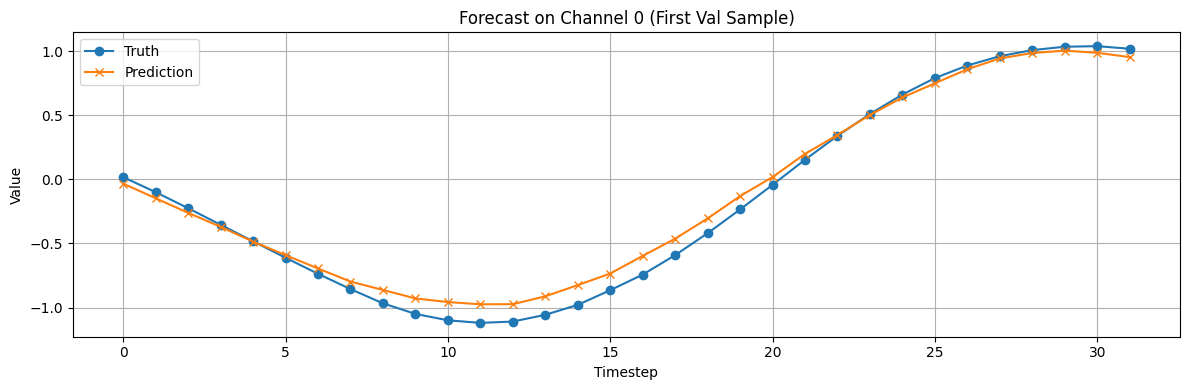

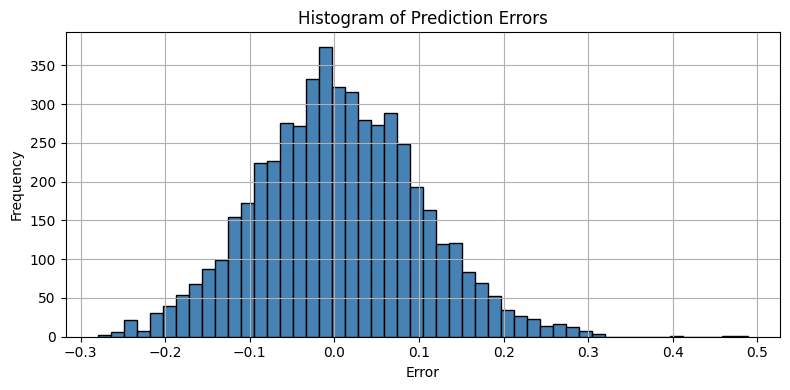

✅ Saved forecast results to forecast_outputs.csv


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# Ensure model is in eval mode
# Load config (must match training)
best_model = PatchTSTModel(best_cfg).to(device)

# Load saved weights
best_model.load_state_dict(torch.load("final_model.pt"))

# Set to eval mode
best_model.eval()


xb, yb = next(iter(val_loader))
xb, yb = xb.to(device), yb.to(device)

# Predict
with torch.no_grad():
    pred = best_model(xb)

# Convert to NumPy
yb_np = yb.cpu().numpy()
pred_np = pred.cpu().numpy()

# Compute metrics
mse = mean_squared_error(yb_np.flatten(), pred_np.flatten())
mae = mean_absolute_error(yb_np.flatten(), pred_np.flatten())
r2 = r2_score(yb_np.flatten(), pred_np.flatten())

print(f"📊 Validation Metrics:\nMSE: {mse:.5f}\nMAE: {mae:.5f}\nR² Score: {r2:.5f}")

# Plot forecast vs truth for 1st sample
ch = 0  # adjust if needed
plt.figure(figsize=(12, 4))
plt.plot(yb_np[0, :, ch], label='Truth', marker='o')
plt.plot(pred_np[0, :, ch], label='Prediction', marker='x')
plt.title(f'Forecast on Channel {ch} (First Val Sample)')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Plot histogram of errors
errors = pred_np - yb_np
plt.figure(figsize=(8, 4))
plt.hist(errors.flatten(), bins=50, color='steelblue', edgecolor='black')
plt.title('Histogram of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()
plt.tight_layout()
plt.show()

# Save to CSV
df = pd.DataFrame({
    'truth': yb_np.flatten(),
    'prediction': pred_np.flatten()
})
df.to_csv("forecast_outputs.csv", index=False)
print("✅ Saved forecast results to forecast_outputs.csv")


In [ ]:

torch.save(model.state_dict(), 'patchtst_voltage_model.pth')
print('Model saved to patchtst_voltage_model.pth')


Model saved to patchtst_voltage_model.pth


In [ ]:
torch.save(model.state_dict(), 'patchtst_voltage_model.pth_checkpoint_1')


## Results summary

| Metric | Value |
|--------|-------|
| Validation MSE | *(fill after training)* |

These preliminary numbers show that PatchTST can forecast the next 32 min of all five voltage channels given the preceding 256 min context.  Replace the hyper‑parameters, run longer training (e.g. 50–100 epochs), and include additional runs to produce the final tables and figures for the manuscript.


Reduce Patch length to capture fine grained details in the channels. Keep stride length < Patch length to get more overlapping between patches, this can potentially capture long range dependencies better and improve context awareness. But this also makes it more sensitive to noise and overiting - there's a trade-off
